In [1]:
import os
import time
import math
import random
import datetime
from pathlib import Path
!pip install transformers
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # reduce the amount of console output from TF
import tensorflow as tf
from transformers import *
!pip install -q datasets # install HF datasets library
from datasets import load_dataset
import torch

logging.set_verbosity_warning()
logging.set_verbosity_error()

import logging

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 14.0 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.3 MB/s eta 0:00:00


In [ ]:
|torch.__version__

'2.0.0+cu118'

In [ ]:
print('TF version',tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # check GPU available

TF version 2.12.0
Num GPUs Available:  1


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load Dataset

In [ ]:
dataset_full = load_dataset("mbpp")

Generating train split:   0%|          | 0/374 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/90 [00:00<?, ? examples/s]

Generating prompt split:   0%|          | 0/10 [00:00<?, ? examples/s]

Dataset mbpp downloaded and prepared to /root/.cache/huggingface/datasets/mbpp/full/1.0.2/4458a31cd4305553c8e88e3f0bfb94fc74fe1a9faeeb8c32ed166939735eaeff. Subsequent calls will reuse this data.


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
test_set = dataset_full['test']

In [ ]:
test_set[3]

{'task_id': 14,
 'text': 'Write a python function to find the volume of a triangular prism.',
 'code': 'def find_Volume(l,b,h) : \r\n    return ((l * b * h) / 2) ',
 'test_list': ['assert find_Volume(10,8,6) == 240',
  'assert find_Volume(3,2,2) == 6',
  'assert find_Volume(1,2,1) == 1'],
 'test_setup_code': '',
 'challenge_test_list': []}

# Model codet5-large-ntp-py

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-large-ntp-py")

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-large-ntp-py").to(device);

In [ ]:
# def make_prediction(model, input_ids: list, max_length=128):
#   outputs = model.generate(input_ids, max_length=max_length)
#   return tokenizer.decode(outputs[0], skip_special_tokens=True)

- Example 1: Few-shot

In [ ]:
text = """Write a python function to remove first\nand last occurrence of a given\ncharacter from the string. Your code\nshould satisfy these tests:\n assert remove_Occ("hello","l") == "heo"\n assert remove_Occ("abcda","a") == "bcd"\n assert remove_Occ("PHP","P") == "H" """

In [ ]:
print(text)

Write a python function to remove first
and last occurrence of a given
character from the string. Your code
should satisfy these tests:
 assert remove_Occ("hello","l") == "heo"
 assert remove_Occ("abcda","a") == "bcd"
 assert remove_Occ("PHP","P") == "H" 


In [ ]:
model_inputs = tokenizer(text, return_tensors="pt")

- Example 2: Few-shot

In [ ]:
text = test_set[1]['text'] + ' Your code should satisfy these tests:\n' +'\n'.join(test_set[1]['test_list'])

In [ ]:
text

'Write a function to sort a given matrix in ascending order according to the sum of its rows. Your code should satisfy these tests:\nassert sort_matrix([[1, 2, 3], [2, 4, 5], [1, 1, 1]])==[[1, 1, 1], [1, 2, 3], [2, 4, 5]]\nassert sort_matrix([[1, 2, 3], [-2, 4, -5], [1, -1, 1]])==[[-2, 4, -5], [1, -1, 1], [1, 2, 3]]\nassert sort_matrix([[5,8,9],[6,4,3],[2,1,4]])==[[2, 1, 4], [6, 4, 3], [5, 8, 9]]'

- Example 3: Pass@k

In [ ]:
text = """Write a python function to remove first and last occurrence of a given character from the string. Your code should satisfy these tests:\n assert remove_Occ("hello","l") == "heo"\n assert remove_Occ("abcda","a") == "bcd"\n assert remove_Occ("PHP","P") == "H" """

In [ ]:
%%time
model_inputs = tokenizer(text, return_tensors="pt").to(device)

CPU times: user 1.08 ms, sys: 18 µs, total: 1.1 ms
Wall time: 1.12 ms


In [ ]:
# output_1 = model.generate(model_inputs.input_ids, max_length=128)

In [ ]:
%%time
output_2 = model.generate(model_inputs.input_ids, max_length=128, num_beams=80, num_return_sequences=80, early_stopping=True)
  # return tokenizer.decode(outputs[0], skip_special_tokens=True)

CPU times: user 2.7 s, sys: 58.7 ms, total: 2.76 s
Wall time: 2.87 s


In [ ]:
%%time
output_2 = model.generate(model_inputs.input_ids, max_length=128, num_beams=80, num_return_sequences=80, early_stopping=True)
  # return tokenizer.decode(outputs[0], skip_special_tokens=True)

CPU times: user 1min 41s, sys: 1.22 s, total: 1min 42s
Wall time: 2min 10s


In [ ]:
# # now we have 3 output sequences
# print("Output:\n")
# list_of_outputs = []
# for i, beam_output in enumerate(output_2):
#   output = tokenizer.decode(beam_output, skip_special_tokens=True)
#   list_of_outputs.append(output)
#   print("{}: {}".format(i, output))

In [ ]:
# exec("""def remove_Occ(string, char):
#     return string[1:-1].replace(char, "")""")

In [ ]:
# exec('assert remove_Occ("hello","l") == "heo"')

# Prediction

In [ ]:
import csv
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Max length on test set
# max([len(i['code'])for i in test_set])

In [ ]:
def make_prediction(model, input_ids: list, max_length=128, batch=False,**kwargs):
  outputs = model.generate(input_ids, max_length=max_length, **kwargs)
  if batch:
    outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
  else:
    outputs = tokenizer.decode(outputs[0], skip_special_tokens=True)
  return outputs

In [ ]:
def save_output(output_file: str, data: list, header):
  # Create file if it doesn't exist
  if not os.path.exists(output_file):
    with open(output_file, "a+", encoding='utf-8') as f:
        write = csv.writer(f)
        write.writerows([header])
  results_df = pd.DataFrame.from_records(data, columns=header)
  results_df.to_csv(output_file, mode='a', index=False, header=None)

- Single Prection

In [ ]:
# MAX_LENGTH = 1331
results = []
# list_of_inputs = []
# list_of_true_labels = []
# list_of_predictions = []
full_path = '/content/drive/MyDrive/CSCI544/Project'
model_name = 'codet5-large-ntp-py'
output_file = f"{full_path}/{model_name}-pred.csv"
for sample in test_set:
  task_id = sample['task_id']
  example = sample['text']
  true_label = sample['code']
  max_length = len(true_label)
  inputs = example + ' Your code should satisfy these tests:\n ' +'\n '.join(sample['test_list'])
  model_inputs = tokenizer(inputs, return_tensors="pt") # prediction with same lengh as output
  output = make_prediction(model, model_inputs.input_ids, max_length=max_length)
  # list_of_inputs.append([inputs]) 
  # list_of_predictions.append([output])
  # list_of_true_labels.append([true_label])
  result = [{'task_id': task_id, 'text': example, 'test_list': sample['test_list'],
             'input': inputs, 'true_label': true_label, 'prediction': output}]
  results.append(result)
  save_output(output_file, result)
  # break

- Multiple Predictions (num_return_sequences)

In [ ]:
print('Model on GPU?: ', next(model.parameters()).is_cuda)

Model on GPU?:  True


In [ ]:
# MAX_LENGTH = 1331
results = []
# list_of_inputs = []
# list_of_true_labels = []
# list_of_predictions = []
full_path = '/content/gdrive/MyDrive/CSCI544/Project'
model_name = 'codet5-large-ntp-py-multiple-sentences-2'
output_file = f"{full_path}/{model_name}-pred.csv"
for sample in test_set:
  task_id = sample['task_id']
  example = sample['text']
  true_label = sample['code']
  max_length = len(true_label)
  inputs = example + ' Your code should satisfy these tests:\n ' +'\n '.join(sample['test_list'])
  model_inputs = tokenizer(inputs, return_tensors="pt").to(device) # prediction with same lengh as output
  output = make_prediction(model, model_inputs.input_ids, max_length=max_length, batch=True,
                           num_beams=80, num_return_sequences=80, early_stopping=True)
  del model_inputs
  # list_of_inputs.append([inputs]) 
  # list_of_predictions.append([output])
  # list_of_true_labels.append([true_label])
  result = [{'task_id': task_id, 'text': example, 'test_list': sample['test_list'],
             'input': inputs, 'true_label': true_label, 'prediction': output}]
  results.append(result)
  save_output(output_file, result, header=['task_id', 'text', 'test_list',
             'input', 'true_label', 'prediction'])

OutOfMemoryError: ignored

# Evaluation

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import pandas as pd
import logging
import csv
logger = logging.getLogger('Evaluation')

logger.setLevel(logging.DEBUG)# allow DEBUG level messages to pass through the logger

In [ ]:
import sys

recursion_limit = sys.getrecursionlimit()
print(f"Current recursion limit: {recursion_limit}")

Current recursion limit: 1000


In [ ]:
nltk.download('punkt');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
full_path = '/content/drive/MyDrive/CSCI544/Project'
model_name = 'codet5-large-ntp-py'
output_file = f"{full_path}/{model_name}-pred.csv"

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-pred.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-pred-manually-cleaned.csv')


# Example of manual processing:

# - remove unnecessary print statements
# - retrieve function
# - remove quotes (""")

In [ ]:
sentences = df[['true_label', 'prediction']].values

- Bleu Score

In [ ]:
def compute_bleu_score(sentences: np.array) -> float:
  n_rows = sentences.shape[0]
  bleu_scores = []
  max_ngram_size = 4

  # define the smoothing function
  smooth_fn = SmoothingFunction() # Smoothing method 1: Add epsilon counts to precision with 0 counts.

  for i in range(n_rows):
    reference = sentences[i][0] # true label
    candidate = sentences[i][1] # prediction
    # Tokenize
    true_token = word_tokenize(reference)
    pred_token = word_tokenize(candidate)
    score = nltk.translate.bleu_score.sentence_bleu(
        [true_token], pred_token, weights=[1./max_ngram_size]*max_ngram_size,
        smoothing_function=smooth_fn.method1)
    bleu_scores.append(score)

  # compute the average BLEU score over all candidate sentences
  avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
  return avg_bleu_score


In [ ]:
print('Bleu Score: ', compute_bleu_score(sentences))

Bleu Score:  0.10143968640805599


- Synthesis Performance

In [ ]:
rows = df[['task_id', 'test_list','true_label', 'prediction']].head(100).values

In [ ]:
acc_list = []
error_messages = []
result = []
logger.info('Starting loop')

for i, row in enumerate(rows):
  task_id, test_list, true_label, prediction = row
  logger.info(f'Processing item {i+1} of {len(rows)}. Task_id: {task_id}')
  test_list = eval(test_list) # evaluate the string representation of each list as a Python expression
  # Get code after 'def'
  try:
    def_index = prediction.find('def')  # find the index of the 'def' keyword
    function_def = prediction[def_index:]  # extract the substring starting from 'def'
  except:
    function_def = ''
  error_list = []
  count_success = 0
  try:
    if task_id != 45:   
      exec(function_def)
      for i, test in enumerate(test_list):
        try:
          exec(test)
          error_list.append(f'Test {i} Success')
          count_success += 1
        except Exception as e:
          # print(type(e))
          if not len(function_def):
            error_list.append(f'Test {i} No Result')
          else:  
            error_list.append(f'Test {i} {type(e)}: {e}')
    else:
      error_list.append(f"Test {i}: <class \'RecursionError\'>: maximum recursion depth exceeded in comparison")

  except Exception as e:
    error_list.append(f'{type(e)}: {e}')
  acc_list.append(count_success/len(test_list))
  error_messages.append(error_list)
  result.append(
      {'task_id': task_id, 'test_list': test_list, 'true_label': true_label,
       'prediction': prediction, 'prediction_cleaned': function_def, 'successful_test_cases': count_success,
       'error_list': error_list})


INFO:Evaluation:Starting loop
INFO:Evaluation:Processing item 1 of 100. Task_id: 11
INFO:Evaluation:Processing item 2 of 100. Task_id: 12
INFO:Evaluation:Processing item 3 of 100. Task_id: 13
INFO:Evaluation:Processing item 4 of 100. Task_id: 14
INFO:Evaluation:Processing item 5 of 100. Task_id: 15
INFO:Evaluation:Processing item 6 of 100. Task_id: 16
INFO:Evaluation:Processing item 7 of 100. Task_id: 17
INFO:Evaluation:Processing item 8 of 100. Task_id: 18
INFO:Evaluation:Processing item 9 of 100. Task_id: 19
INFO:Evaluation:Processing item 10 of 100. Task_id: 20
INFO:Evaluation:Processing item 11 of 100. Task_id: 21
INFO:Evaluation:Processing item 12 of 100. Task_id: 22
INFO:Evaluation:Processing item 13 of 100. Task_id: 23
INFO:Evaluation:Processing item 14 of 100. Task_id: 24
INFO:Evaluation:Processing item 15 of 100. Task_id: 25
INFO:Evaluation:Processing item 16 of 100. Task_id: 26
INFO:Evaluation:Processing item 17 of 100. Task_id: 27
INFO:Evaluation:Processing item 18 of 100. T

0
1
0
10090807060504030201
1
20019018017016015014013012011010090807060504030201


In [ ]:
output_file = "/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-eval-with-prediction-100.csv"
save_output(output_file, result, header=['task_id', 'test_list', 'true_label',
       'prediction', 'prediction_cleaned', 'successful_test_cases',
       'error_list'])

### Compute metric

- Passing all 3 test cases

In [ ]:
acc_all_test_cases = [1 if acc == 1 else 0 for acc in acc_list]

In [ ]:
import builtins

In [ ]:
print(f'Tasks Solved: {builtins.sum(acc_all_test_cases)/len(acc_all_test_cases)*100:.2f}%')

Tasks Solved: 14.40%


- Passing at least 2 test cases

In [ ]:
acc_all_test_cases = [1 if acc > 0.5 else 0 for acc in acc_list]

In [ ]:
print(f'Tasks Solved: {builtins.sum(acc_all_test_cases)/len(acc_all_test_cases)*100:.2f}%')

Tasks Solved: 19.00%


- Passing at least 1 test case

In [ ]:
acc_all_test_cases = [1 if acc > 0 else 0 for acc in acc_list]

In [ ]:
print(f'Tasks Solved: {builtins.sum(acc_all_test_cases)/len(acc_all_test_cases)*100:.2f}%')

Tasks Solved: 26.40%


### Pass @k

The pass@k is the fraction of prompts for which the model succeeded in this sense.

For example, if Pass@5 is 80%, it means that for 80% of the queries, the system returned at least one relevant document among the top 5 results.

It robustly estimates the probability that one of k generations passes the tests

Reference: https://twitter.com/lvwerra/status/1474072790785564673

In [2]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.2 MB/s eta 0:00:00


In [3]:
from evaluate import load

In [4]:
import os
import pandas as pd

os.environ["HF_ALLOW_CODE_EVAL"] = "1"
# code_eval = load("code_eval")

In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" # => solve colab error: NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [6]:
def compute_pass_k_metric(test_cases: list[list], candidates: list[list], k: list) -> tuple[dict, dict]:
  '''The Code Eval metric calculates how good are predictions given a set of references
  https://huggingface.co/spaces/evaluate-metric/code_eval

  Args:
    test_cases
    candidates
    k
  Returns:
    (dict, dict)
  '''
  # Join test cases into a single string.
  test_cases_joined = ['\n'.join(test) for test in test_cases]
  pass_at_k, results = code_eval.compute(references=test_cases_joined, predictions=candidates, k=k)
  return pass_at_k, results

In [7]:
df = pd.read_csv('/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-multiple-sentences-pred.csv')

In [8]:
df = df.drop_duplicates(subset=['task_id']).head(100)

In [9]:
code_eval = load("code_eval")

In [10]:
def post_processing(prediction: list) -> list:
  '''Get string after 'def' statement
  '''
  output = []
  for pred in prediction:
      def_index = pred.find('def') # get only function
      output.append(pred[def_index:])
  return output

In [11]:
# Clean output
df['prediction_cleaned'] = df['prediction'].apply(lambda x: post_processing(eval(x)))

In [ ]:
# df.to_csv('/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-multiple-sentences-pred-cleaned.csv', index=False)

In [ ]:
pass_k_test = []
pass_k_predictions = []
for test, pred in zip(df['test_list'], df['prediction_cleaned']):
    pass_k_test.append(eval(test))
    pass_k_predictions.append(pred)

In [ ]:
%%time
pass_at_k, results = compute_pass_k_metric(pass_k_test, pass_k_predictions, [1,2,5,80])

CPU times: user 59.1 s, sys: 9min 11s, total: 10min 10s
Wall time: 15min 41s


In [ ]:
# %%time
# pass_at_k, results = compute_pass_k_metric(pass_k_test, pass_k_predictions, [1,2,5,80])

In [ ]:
len(pass_k_test)

331

In [ ]:
pass_at_k

{'pass@1': 0.11999999999999997,
 'pass@2': 0.17129113924050632,
 'pass@5': 0.22866582576317754,
 'pass@80': 0.38}

In [ ]:
pass_at_k

{'pass@1': 0.1183157099697885,
 'pass@2': 0.1681326245745535,
 'pass@5': 0.2299849467905608,
 'pass@80': 0.3776435045317221}

In [ ]:
import json

# as requested in comment
results = {'results': results}

with open('/content/drive/MyDrive/CSCI544/Project/pass_k_metric_results.txt', 'w') as file:
     file.write(json.dumps(results))

In [ ]:
# a = [i[i.find('def'):] for i in list_of_outputs]

In [ ]:
# from evaluate import load
# code_eval = load("code_eval")
# test_cases = ["assert add(2,3)==5"]
# candidates = [["def add(a,b): return a*b", "def add(a, b): return a+b", "def add(a, b): return a-b"]]
# test_cases_2 = ['assert remove_Occ("hello","l") == "heo"\nassert remove_Occ("abcda","a") == "bcd"\nassert remove_Occ("PHP","P") == "H"']
# candidates_2 = [a]

In [ ]:
# from evaluate import load
# code_eval = load("code_eval")
# test_cases = ["assert add(2,3)==5"]
# candidates = [["def add(a,b): return a*b", "def add(a, b): return a+b", "def add(a, b): return a-b"]]
# test_cases_2 = ['assert remove_Occ("hello","l") == "heo"\nassert remove_Occ("abcda","a") == "bcd"\nassert remove_Occ("PHP","P") == "H"']
# candidates_2 = [a[:-1]]

### What sort of errors the model makes?

According to "CodeRL: Mastering Code Generation through Pretrained Models and Deep Reinforcement Learning" paper, we can classify the error in 4 different categories:
- "Compile Error"
- "Runtime Error"
- "Failed Test"
- "Passed Test"

In [17]:
from collections import Counter

In [12]:
# df_eval = pd.read_csv('/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-eval.csv')
df_eval = pd.read_csv('/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-eval-with-prediction-100.csv')

In [13]:
def retrieve_error_message(error_string: str) -> str or None:
  '''Retrieve error type form string, 
     return None if not found
  '''
  try:
    start_index = error_string.index("<class '") + len("<class '")
    end_index = error_string.index("'>:")
    assertion_error_str = error_string[start_index:end_index]
  except:
    # if no error is found, search for success
    if 'Success' in error_string:
      assertion_error_str = 'Success'
    if 'No Result' in error_string:
      assertion_error_str = 'No Result'
    # Should never happen
    # else:
    #   print(error_string)
    #   assertion_error_str = None
  return assertion_error_str

In [14]:
errors = []
for _, list_of_errors in enumerate(df_eval['error_list'].values):
  tmp = set([retrieve_error_message(error_message) for error_message in eval(list_of_errors)])
  # tmp_count = Counter(tmp)
  errors.append(tmp)

In [22]:
def classify_errors(errors: set) -> str:
  # Only one type of error
  if len(errors) == 1:
    if 'AssertionError' in errors:
      error_class = 'FailedTest'
    elif 'Success' in errors:
      error_class = 'PassedAllTest'
    elif 'SyntaxError' in errors:
      error_class = 'CompileError'
    elif 'No Result' in errors:
      error_class = 'No Result'
    else:
      error_class = 'RuntimeError'
  else:
    if 'Success' in errors:
      error_class = 'PassedOneOrTwoTests'
    else:
      error_class = 'RuntimeError'

  return error_class

In [23]:
errors_class = [classify_errors(error) for error in errors]
errors_class = Counter(errors_class)

In [24]:
errors_class

Counter({'RuntimeError': 16,
         'FailedTest': 36,
         'PassedAllTest': 21,
         'CompileError': 8,
         'PassedOneOrTwoTests': 18,
         'No Result': 1})

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import builtins

In [26]:
errors_class

Counter({'RuntimeError': 16,
         'FailedTest': 36,
         'PassedAllTest': 21,
         'CompileError': 8,
         'PassedOneOrTwoTests': 18,
         'No Result': 1})

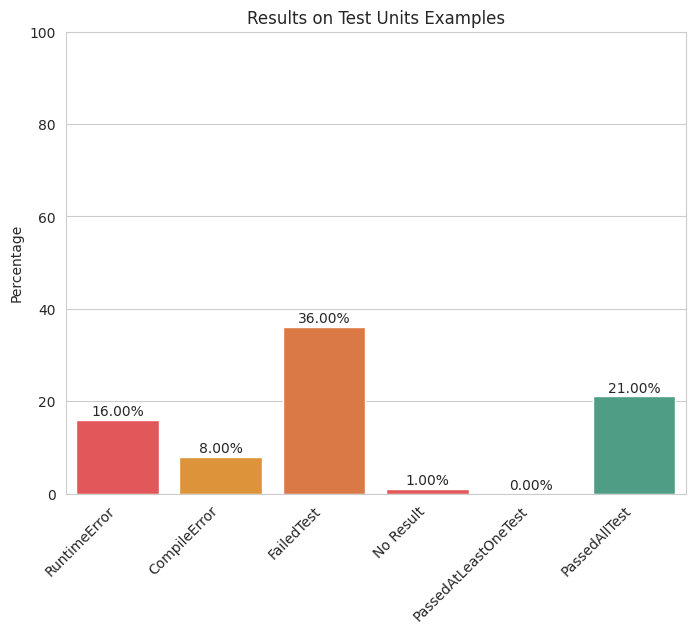

In [27]:
# Calculate the total number of items in the Counter
total = builtins.sum(errors_class.values())


label_order= ['RuntimeError', 'CompileError', 'FailedTest', 'No Result', 'PassedAtLeastOneTest', 'PassedAllTest']

errors_class = {label: errors_class[label]for label in label_order}

# Calculate the percentage of each item in the Counter
percentages = [(count/total)*100 for count in errors_class.values()]

# Define custom colors
colors_dict = {'RuntimeError': '#f94144',
               'FailedTest': '#f3722c',
               'PassedAllTest': '#43aa8b',
               'CompileError': '#f8961e',
               'PassedAtLeastOneTest': '#90be6d',#90be6d
               'No Result': '#f94144'
               }

# Convert the dictionary of colors to a list
colors = [colors_dict[label] for label in errors_class.keys()]

# Create a Seaborn bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=list(errors_class.keys()), y=percentages, palette=colors, order=label_order)
ax.set_title("Results on Test Units Examples")
# ax.set_xlabel("Error Type")
ax.set_ylabel("Percentage")
ax.set_ylim([0, 100])
plt.xticks(rotation=45, ha='right')

# Add the percentage values on the bars
for i, v in enumerate(percentages):
    ax.text(i, v + 1, f"{v:.2f}%", ha='center')

plt.show()

# CodeGen and CodeT5 graphs

In [30]:
# df_eval = pd.read_csv('/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-eval.csv')
df_eval = pd.read_csv('/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-eval-with-prediction-100.csv')
df_eval_gen = pd.read_csv('/content/drive/MyDrive/CSCI544/Project/codegen-2B-mono-eval.csv')

In [46]:
errors = []
for _, list_of_errors in enumerate(df_eval['error_list'].values):
  tmp = set([retrieve_error_message(error_message) for error_message in eval(list_of_errors)])
  # tmp_count = Counter(tmp)
  errors.append(tmp)

In [47]:
errors_gen = []
for _, list_of_errors in enumerate(df_eval_gen['error_list'].values):
  tmp = set([retrieve_error_message(error_message) for error_message in eval(list_of_errors)])
  # tmp_count = Counter(tmp)
  errors_gen.append(tmp)

In [48]:
errors_class = [classify_errors(error) for error in errors]
errors_class = Counter(errors_class)

In [49]:
errors_class_gen = [classify_errors(error) for error in errors_gen]
errors_class_gen = Counter(errors_class_gen)

In [74]:
total_counts

Model
CodeGen    100
CodeT5     100
Name: Count, dtype: int64

In [112]:
sns.set_style("white")
# sns.set(rc={'figure.figsize':(5, 2)})

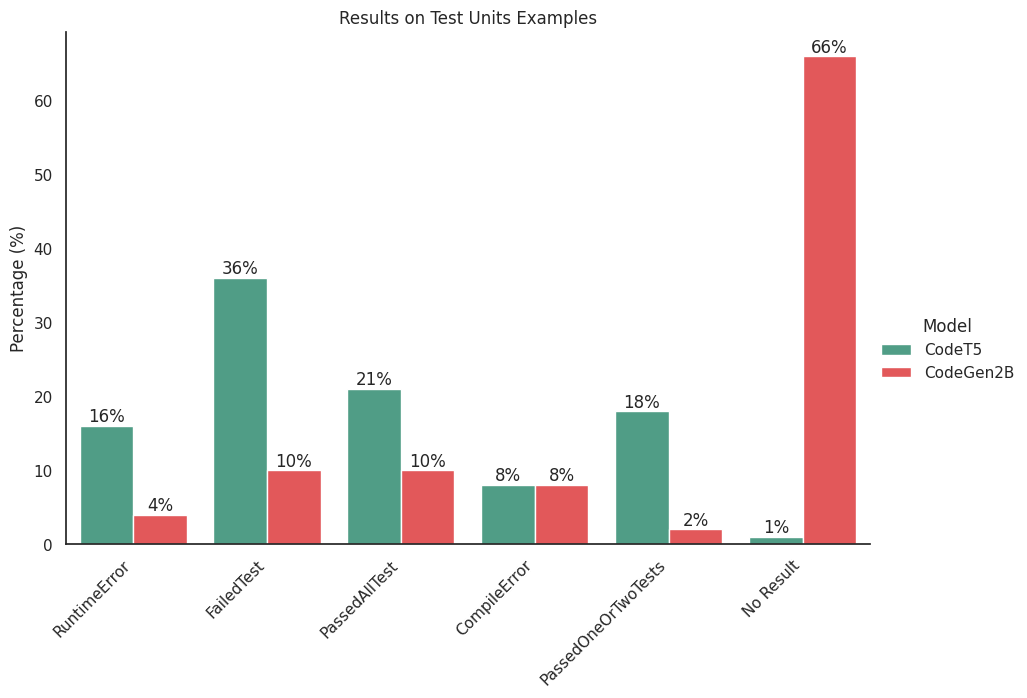

In [114]:

df = pd.DataFrame({'CodeT5': errors_class, 'CodeGen2B': errors_class_gen})
df = df.reset_index().rename(columns={'index': 'Status'})
df_melt = pd.melt(df, id_vars=['Status'], var_name='Model', value_name='Count')


total_counts = df_melt.groupby('Model')['Count'].sum()
df_melt['Percentage'] = df_melt.apply(lambda x: x['Count'] / total_counts[x['Model']] * 100, axis=1)

ax = sns.catplot(x='Status', y='Count', hue='Model', data=df_melt, kind='bar', 
            height=6, aspect=1.5, palette=['#43aa8b', '#f94144'])#, figsize=(10, 7))
plt.title('Results on Test Units Examples')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage (%)')
ax.set(xlabel=None)
for p in ax.ax.patches:
    ax.ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f"{int(p.get_height())}%", 
                ha='center', va='bottom')
plt.show()

# TO DO:

 - [x] Compare performance with 0, 1, 2 or 3 test cases
 - [ ] Split error types in: CompileError, RuntimeError, FailedTest, and PassedTest